# Don't Overfit! II

<a href="https://www.kaggle.com/c/dont-overfit-ii">Link to competition on Kaggle</a>

Inspiration taken from the following Kaggle kernels:
- <a href="https://www.kaggle.com/featureblind/robust-lasso-patches-with-rfe-gs">Robust, Lasso, Patches with RFE & GS</a>
- <a href="https://www.kaggle.com/gpreda/overfitting-the-private-leaderboard">Overfitting the private leaderboard</a>

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
from time import time, sleep
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score, r2_score, make_scorer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (16, 9)
np.random.seed(888)

## Load Data

In [4]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

train_y = train['target']
train_X = train.drop(['id', 'target'], axis=1).values
test_X = test.drop(['id'], axis=1).values

In [5]:
train.head()

,id,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,-2.246,1.825,-0.912,-0.107,0.305,0.102,0.826,0.417,0.177,-0.673,-0.503,1.864,0.410,-1.927,0.102,-0.931,1.763,1.449,-1.097,-0.686,-0.250,-1.859,1.125,1.009,-2.296,0.385,-0.876,1.528,-0.144,-1.078,-0.403,0.005,1.405,-0.044,-0.458,0.579,2.929,0.833,0.761,0.737,0.669,0.717,-1.542,-1.847,-0.445,1.238,-0.840,-1.891,-1.531,-0.396,-0.927,2.072,0.946,-1.105,0.008,0.933,-1.410,-0.770,1.740,-1.504,-0.391,-1.551,-1.415,-0.974,0.796,-2.464,-1.424,1.230,0.219,0.130,-0.371,-0.930,1.851,1.292,-0.380,1.318,1.146,-0.399,2.227,0.447,0.870,1.420,-1.675,0.019,0.060,0.768,2.563,0.638,1.164,0.407,-1.556,-0.903,1.329,0.452,-0.704,2.218,-1.844,0.158,-1.649,-0.172,-1.167,-1.456,-0.778,0.098,-1.627,0.405,-0.082,-0.797,-0.303,0.710,-0.252,1.920,0.706,-0.915,0.267,-0.607,0.966,-0.337,-2.292,-1.366,-1.085,0.278,0.212,1.260,-1.276,-2.013,-1.101,0.797,0.661,1.232,-0.632,-0.805,1.236,-1.085,-0.067,-0.661,-0.745,1.306,-0.010,-0.475,-0.613,-0.841,-0.837,0.671,2.493,0.689,0.946,0.160,-0.607,-0.775,1.688,0.302,-1.156,-0.718,0.126,0.745,-0.287,-0.565,0.646,-0.119,-0.675,-0.479,-0.191,-0.454,1.314,0.740,0.999,1.242,-0.339,0.403,-1.243,1.365,0.030,-0.475,0.860,0.036,1.313,-0.219,1.078,1.880,-0.317,-0.443,1.876,-0.611,0.892,1.435,-0.226,0.311,0.139,-0.075,1.381,1.716,-2.017,-0.485,1.906,-0.119,0.609,-0.564,0.264,-0.604,-0.733,-2.352,-1.661,0.498,-0.841,0.907,-0.476,0.817,1.372,1.187,0.844,0.028,0.029,-0.808,0.253,1.005,1.413,-0.133,0.655,-0.921,0.231,-1.902,-0.005,-1.730,1.132,-0.194,0.039,1.489,-0.328,0.966,-0.057,-0.181,0.723,-0.313,-0.165,-0.803,0.074,-2.851,-1.021,-0.894,0.967,0.218,-0.692,-0.514,0.754,-1.892,0.203,2.174,-0.755,-1.053,-0.516,-1.109,-0.681,1.250,-0.565,-1.318,-0.923,0.075,-0.704,2.457,0.771,-0.460,0.569,-1.320,-1.516,-2.145,-1.120,0.156,0.820,-1.049,-1.125,0.484,0.617,1.253,1.248,0.504,-0.802,-0.896,-1.793,-0.284,-0.601,0.569,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,0.004,-0.291,2.907,1.085,2.144,1.540,0.584,1.133,1.098,-0.237,-0.498,0.283,-1.100,-0.417,1.382,-0.515,-1.519,0.619,-0.128,0.866,-0.540,1.238,-0.227,0.269,-0.390,-2.721,1.659,0.106,-0.121,1.719,0.411,-0.303,-0.307,0.380,0.503,-1.320,0.339,-1.102,-0.947,0.267,0.695,0.167,0.188,-1.082,-0.872,0.660,0.051,0.303,-0.553,-0.771,0.588,0.472,1.315,-0.467,-0.064,1.808,0.633,1.221,1.112,1.133,-0.543,-2.144,0.151,-0.813,1.966,-1.190,0.190,-0.473,0.002,1.195,-0.799,1.117,-0.759,-0.661,0.406,-0.846,-0.035,-1.634,-0.011,0.503,0.610,-1.822,-0.030,1.188,-0.006,-0.279,1.914,0.620,-1.495,1.787,-0.305,0.602,-1.208,0.893,0.379,1.396,0.581,-0.475,-0.056,-0.691,-0.783,-1.485,1.911,-2.400,-2.372,-0.178,1.550,-0.228,0.674,0.987,1.373,-0.373,0.629,0.229,-0.630,-0.175,0.548,0.074,-2.090,-0.625,-1.131,1.111,-0.100,0.574,-0.660,-1.113,0.802,-0.093,1.302,-0.395,0.745,-0.384,0.066,-0.756,0.495,-0.8

## Exploratory Data Analysis

### Distribution of Means

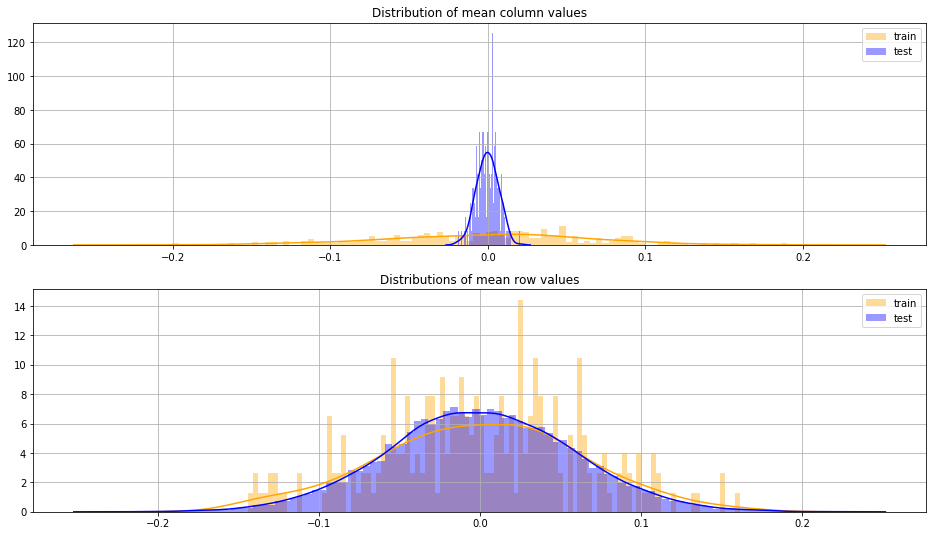

In [6]:
fig, ax = plt.subplots(2, 1)
sns.distplot(train[train.columns[2:]].mean(), bins=100, label='train', color='orange', ax=ax[0])
sns.distplot(test[test.columns[1:]].mean(), bins=100, label='test', color='blue', ax=ax[0])
sns.distplot(train[train.columns[2:]].mean(axis=1), bins=100, label='train', color='orange', ax=ax[1])
sns.distplot(test[test.columns[1:]].mean(axis=1), bins=100, label='test', color='blue', ax=ax[1])
ax[0].set_title('Distribution of mean column values')
ax[1].set_title('Distributions of mean row values')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

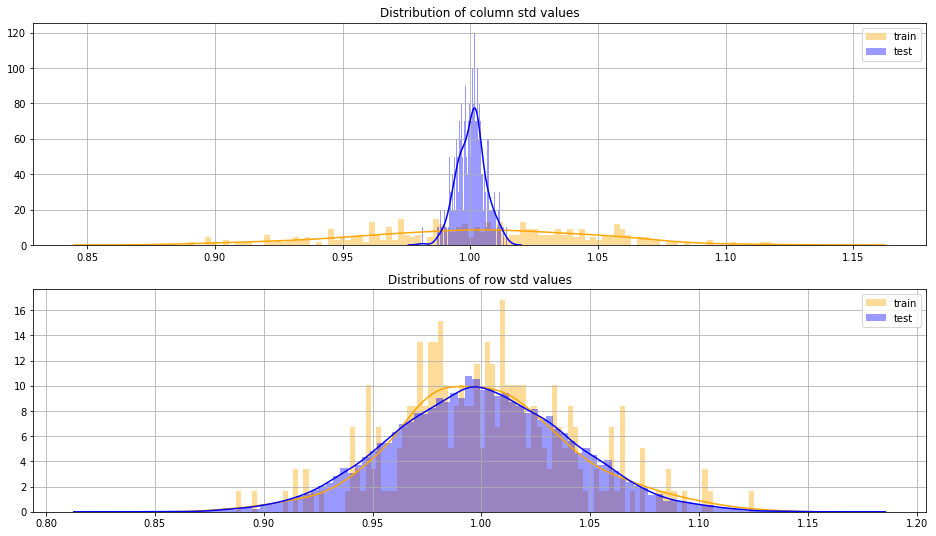

In [7]:
fig, ax = plt.subplots(2, 1)
sns.distplot(train[train.columns[2:]].std(), bins=100, label='train', color='orange', ax=ax[0])
sns.distplot(test[test.columns[1:]].std(), bins=100, label='test', color='blue', ax=ax[0])
sns.distplot(train[train.columns[2:]].std(axis=1), bins=100, label='train', color='orange', ax=ax[1])
sns.distplot(test[test.columns[1:]].std(axis=1), bins=100, label='test', color='blue', ax=ax[1])
ax[0].set_title('Distribution of column std values')
ax[1].set_title('Distributions of row std values')
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

## Prepare Data

### Scale

We will scale using RobustScaler across both the training and test data. Although this would be poor practice for a real-world production mahine learning model, it is a sensible approach for this competition.

In [8]:
data = RobustScaler().fit_transform(np.concatenate((train_X, test_X), axis=0))
train_data = data[:250]
test_data = data[250:]

### Add Noise

To reduce overfitting, we can add noise to the training data.

In [9]:
train_data += np.random.normal(0, 0.01, train_data.shape)

## Build Model

### Define Scoring Metric

In [10]:
def scoring_roc_auc(y, y_pred):
    try:
        return roc_auc_score(y, y_pred)
    except:
        return 0.5

roc_auc_scorer = make_scorer(scoring_roc_auc)

## Lasso

### Configure Model

In [11]:
model = Lasso(random_state=888, tol=0.01, alpha=0.030, selection='random')
param_grid = {
    'alpha': [0.020, 0.022, 0.024, 0.026, 0.028, 0.030, 0.032],
    'tol' : [0.0010, 0.0012, 0.0014, 0.0016, 0.0018]
}

### Feature Selection

In [12]:
feature_selector = RFECV(model, min_features_to_select=12, scoring=roc_auc_scorer,
                         step=15, verbose=0, cv=20)


### Train

In [13]:
predictions = pd.DataFrame()
counter = 0
n_splits = 20
start = time()

for train_index, val_index in tqdm_notebook(
    StratifiedShuffleSplit(n_splits=n_splits, test_size=0.35, random_state=888).split(train_X, train_y),
    desc='Shuffle Split'):
        X, val_X = train_data[train_index], train_data[val_index]
        y, val_y = train_y[train_index], train_y[val_index]

        # find the best features for this data
        feature_selector.fit(X, y)
        # remove irrelevant features
        X_important_features = feature_selector.transform(X)
        val_X_important_features = feature_selector.transform(val_X)
        test_important_features = feature_selector.transform(test_data)

        # run grid search
        grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0,
                                   scoring=roc_auc_scorer, cv=20)
        grid_search.fit(X_important_features, y)

        # score
        val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
        val_mse = mean_squared_error(val_y, val_y_pred)
        val_mae = mean_absolute_error(val_y, val_y_pred)
        val_roc = roc_auc_score(val_y, val_y_pred)
        val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_r2 = r2_score(val_y, val_y_pred)

        # save predictions for models that meet a minimum threshold
        # recommended threshold is 0.185
        if val_r2 > 0.175:
            print("Best params: {}, Best score: {:.4f}".format(
                grid_search.best_params_, grid_search.best_score_))
            print("Val ROC: {:.4f}, Val R2: {:.4f}\n".format(val_roc, val_r2))
            prediction = grid_search.best_estimator_.predict(test_important_features)
            predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        else:
            pass

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8942
Val ROC: 0.8220, Val R2: 0.2709

Best params: {'alpha': 0.032, 'tol': 0.001}, Best score: 0.8019
Val ROC: 0.7840, Val R2: 0.1840

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8694
Val ROC: 0.7824, Val R2: 0.2206

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8712
Val ROC: 0.8075, Val R2: 0.2242

Best params: {'alpha': 0.03, 'tol': 0.0018}, Best score: 0.7995
Val ROC: 0.8136, Val R2: 0.2372

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8480
Val ROC: 0.7941, Val R2: 0.2101

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8950
Val ROC: 0.7757, Val R2: 0.1959

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8442
Val ROC: 0.7846, Val R2: 0.2281

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.8956
Val ROC: 0.8465, Val R2: 0.3085

Best params: {'alpha': 0.02, 'tol': 0.001}, Best score: 0.9097
Val ROC: 0.7690, Val R2: 0.1915




In [14]:
predictions_lasso = predictions.copy()
print(predictions.shape)
predictions.head()

(19750, 10)


,0,0,0,0,0,0,0,0,0,0
0,0.720926,0.655820,0.762301,0.670929,0.915512,0.584401,0.805394,0.745767,0.710179,0.842761
1,0.597552,0.630935,0.712125,0.649623,0.546607,0.715689,0.606549,0.666219,0.792010,0.781632
2,0.737939,0.480039,0.998539,0.459894,0.503879,0.450659,0.560475,0.686334,0.656398,0.499837
3,0.632823,0.892209,0.880929,0.747298,0.764328,1.023824,1.253465,0.844091,0.967960,0.823822
4,0.399023,0.656176,0.497023,0.320773,0.629662,0.515569,0.511074,0.777152,0.548320,0.726287


In [15]:
lasso_mean_pred = pd.DataFrame(predictions.mean(axis=1))
lasso_mean_pred.index += 250
lasso_mean_pred.columns = ['target']

## Ridge

### Configure Model

In [16]:
model = Ridge(random_state=888, tol=0.01, alpha=0.030)
param_grid = {
    'alpha': [0.00010, 0.00012, 0.00014, 0.00016, 0.00018],
    'tol' : [0.0010],
    'solver': ['svd', 'saga']
}

### Feature Selection

In [17]:
feature_selector = RFECV(model, min_features_to_select=12, scoring=roc_auc_scorer,
                         step=15, verbose=0, cv=20)

### Train

In [18]:
predictions = pd.DataFrame()
counter = 0
n_splits = 20
start = time()

for train_index, val_index in tqdm_notebook(
    StratifiedShuffleSplit(n_splits=n_splits, test_size=0.35, random_state=888).split(train_X, train_y),
    desc='Shuffle Split'):
        X, val_X = train_data[train_index], train_data[val_index]
        y, val_y = train_y[train_index], train_y[val_index]

        # find the best features for this data
        feature_selector.fit(X, y)
        # remove irrelevant features
        X_important_features = feature_selector.transform(X)
        val_X_important_features = feature_selector.transform(val_X)
        test_important_features = feature_selector.transform(test_data)

        # run grid search
        grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0,
                                   scoring=roc_auc_scorer, cv=20)
        grid_search.fit(X_important_features, y)

        # score
        val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
        val_mse = mean_squared_error(val_y, val_y_pred)
        val_mae = mean_absolute_error(val_y, val_y_pred)
        val_roc = roc_auc_score(val_y, val_y_pred)
        val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_r2 = r2_score(val_y, val_y_pred)

        # save predictions for models that meet a minimum threshold
        # recommended threshold is 0.185
        if val_r2 > 0.12:
            print("Best params: {}, Best score: {:.4f}".format(
                grid_search.best_params_, grid_search.best_score_))
            print("Val ROC: {:.4f}, Val R2: {:.4f}\n".format(val_roc, val_r2))
            prediction = grid_search.best_estimator_.predict(test_important_features)
            predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        else:
            pass

Best params: {'alpha': 0.0001, 'tol': 0.001, 'solver': 'svd'}, Best score: 0.8399
Val ROC: 0.7746, Val R2: 0.1211




In [19]:
predictions_ridge = predictions.copy()
print(predictions.shape)
predictions.head()

(19750, 1)


,0
0,0.868196
1,0.584653
2,0.689028
3,1.035163
4,0.951010


## SVR

### Configure Model

In [22]:
model = SVR(kernel='linear', tol=0.01, degree=2)
param_grid = {
    'kernel': ['linear'],
    'tol' : [0.0010],
    'degree': [2, 3]
}

### Feature Selection

In [23]:
feature_selector = RFECV(model, min_features_to_select=12, scoring=roc_auc_scorer,
                         step=15, verbose=0, cv=20)

### Train

In [24]:
predictions = pd.DataFrame()
counter = 0
n_splits = 20
start = time()

for train_index, val_index in tqdm_notebook(
    StratifiedShuffleSplit(n_splits=n_splits, test_size=0.35, random_state=888).split(train_X, train_y),
    desc='Shuffle Split'):
        X, val_X = train_data[train_index], train_data[val_index]
        y, val_y = train_y[train_index], train_y[val_index]

        # find the best features for this data
        feature_selector.fit(X, y)
        # remove irrelevant features
        X_important_features = feature_selector.transform(X)
        val_X_important_features = feature_selector.transform(val_X)
        test_important_features = feature_selector.transform(test_data)

        # run grid search
        grid_search = GridSearchCV(feature_selector.estimator_, param_grid=param_grid, verbose=0,
                                   scoring=roc_auc_scorer, cv=20)
        grid_search.fit(X_important_features, y)

        # score
        val_y_pred = grid_search.best_estimator_.predict(val_X_important_features)
        val_mse = mean_squared_error(val_y, val_y_pred)
        val_mae = mean_absolute_error(val_y, val_y_pred)
        val_roc = roc_auc_score(val_y, val_y_pred)
        val_cos = cosine_similarity(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_dst = euclidean_distances(val_y.values.reshape(1, -1), val_y_pred.reshape(1, -1))[0][0]
        val_r2 = r2_score(val_y, val_y_pred)

        # save predictions for models that meet a minimum threshold
        # recommended threshold is 0.185
        if val_r2 > 0.12:
            print("Best params: {}, Best score: {:.4f}".format(
                grid_search.best_params_, grid_search.best_score_))
            print("Val ROC: {:.4f}, Val R2: {:.4f}\n".format(val_roc, val_r2))
            prediction = grid_search.best_estimator_.predict(test_important_features)
            predictions = pd.concat([predictions, pd.DataFrame(prediction)], axis=1)
        else:
            pass

Best params: {'degree': 2, 'kernel': 'linear', 'tol': 0.001}, Best score: 0.7327
Val ROC: 0.7612, Val R2: 0.1244




In [25]:
predictions_svm = predictions.copy()
print(predictions.shape)
predictions.head()

(19750, 1)


,0
0,0.475619
1,0.278921
2,0.463583
3,1.211960
4,0.574545


## Compare Models

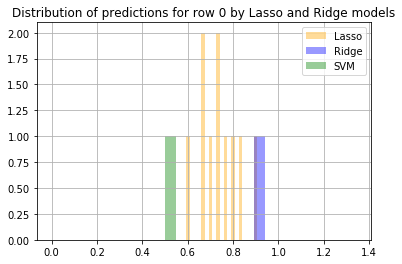

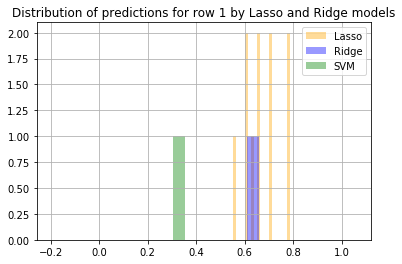

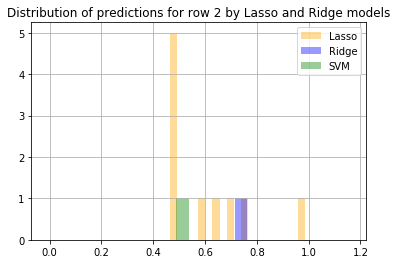

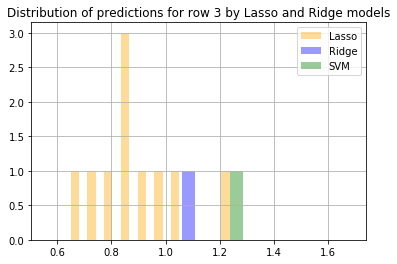

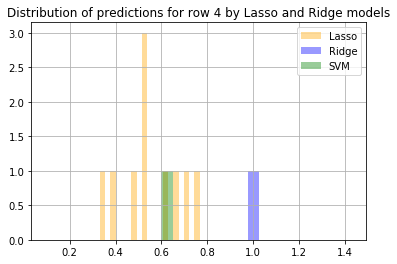

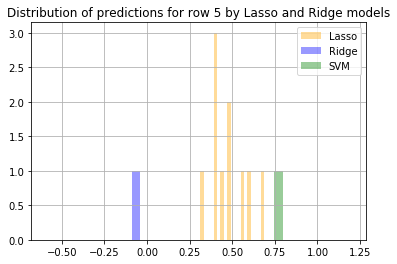

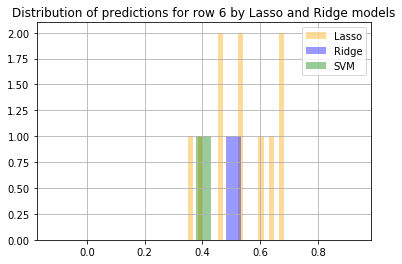

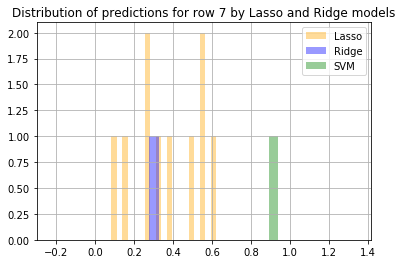

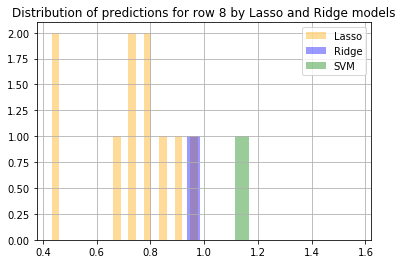

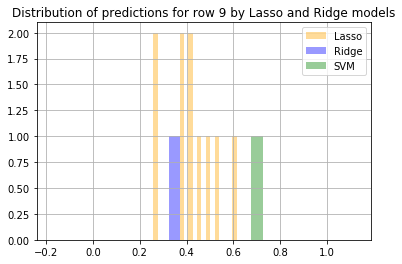

In [26]:
for row in range(10):
    bins = max(len(predictions_lasso.columns), len(predictions_ridge.columns))
    fig, ax = plt.subplots(1, 1)
    sns.distplot(predictions_lasso[predictions_lasso.index == row], label='Lasso', color='orange', bins=bins, ax=ax, kde=False, hist_kws={'rwidth': 0.5})
    sns.distplot(predictions_ridge[predictions_ridge.index == row], label='Ridge', color='blue', bins=bins, ax=ax, kde=False, hist_kws={'rwidth': 0.5})
    sns.distplot(predictions_svm[predictions_svm.index == row], label='SVM', color='green', bins=bins, ax=ax, kde=False, hist_kws={'rwidth': 0.5})
    ax.set_title('Distribution of predictions for row {} by Lasso and Ridge models'.format(row))
    ax.legend()
    ax.grid()
    plt.show()

## Ensemble

In [32]:
all_preds = pd.concat([predictions_lasso, predictions_ridge, predictions_svm], axis=1)
name = datetime.now().strftime("%Y%m%d%H%M%S")
mean_pred = pd.DataFrame(all_preds.mean(axis=1), columns=['target'])
mean_pred.index += 250
mean_pred.to_csv('submissions/{}.csv'.format(name), index_label='id', index=True)
name

'20190427232806'

In [ ]:
break here

# Notes

In [ ]:
from tqdm import tnrange, tqdm_notebook
from time import sleep

for i in tnrange(3, desc='1st loop'):
    for j in tnrange(100, desc='2nd loop'):
        sleep(0.01)

In [ ]:
from tqdm import tnrange, tqdm_notebook
from time import sleep

for i in tnrange(3, desc='1st loop'):
    for j in tqdm_notebook(range(100), desc='2nd loop'):
        sleep(0.01)

Tree methods will probably overfit.

Extensive EDA visualisations comparing distributions here: https://www.kaggle.com/gpreda/overfitting-the-private-leaderboard

In [ ]:
name = datetime.now().strftime("%Y%m%d%H%M%S")
mean_pred = pd.DataFrame(predictions.mean(axis=1))
mean_pred.to_csv('submissions/{}_lasso.csv'.format(name), index_label='id', index=True)
name